<a href="https://colab.research.google.com/github/rebal-akar/skills-introduction-to-github/blob/main/Another_copy_of_ML_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-Supervised

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os, csv, random
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
import math
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed for initial consistency
seed_everything(42)


Dataset Load and Model

In [ ]:
def get_resnet18_fully_supervised(num_classes=10):
    model = torchvision.models.resnet18(pretrained=False)
    # Modify for CIFAR-10: 3x3 conv1, remove maxpool.
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, num_classes)
    return model

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)




100%|██████████| 170M/170M [00:07<00:00, 23.6MB/s]


Load SimCLR model

In [ ]:
simclr_ckpt_path = "/content/drive/MyDrive/Typiclust/simclr_cifar-10.pth"
def load_pretrained_simclr_model(model_path, device):
    class SimCLRModel(nn.Module):
        def __init__(self):
            super(SimCLRModel, self).__init__()
            resnet = torchvision.models.resnet18(pretrained=False)
            resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            resnet.maxpool = nn.Identity()
            resnet.fc = nn.Identity()
            self.encoder = resnet
            self.projector = nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 128)
            )
        def forward(self, x, return_embedding=False):
            h = self.encoder(x)
            h = torch.flatten(h, 1)
            if return_embedding:
                return h
            return self.projector(h)
    model = SimCLRModel().to(device)
    # Load checkpoint, remap keys, etc.
    checkpoint = torch.load(model_path, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for key, value in checkpoint.items():
        if key.startswith("backbone."):
            new_key = "encoder." + key[len("backbone."):]
        elif key.startswith("contrastive_head."):
            new_key = "projector." + key[len("contrastive_head."):]
        else:
            new_key = key
        if "shortcut" in new_key:
            new_key = new_key.replace("shortcut", "downsample")
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Pretrained SimCLR model loaded successfully!")
    return model

simclr_model = load_pretrained_simclr_model(simclr_ckpt_path, device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Pretrained SimCLR model loaded successfully!


Train and Evaluate Functions

In [ ]:
def train_model(model, train_loader, num_epochs=100):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def extract_embeddings(model, loader):
    model.eval()
    feat_model = copy.deepcopy(model)
    feat_model.fc = nn.Identity()
    feat_model = feat_model.to(device)

    all_embeddings = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            feats = feat_model(images,return_embedding=True)
            all_embeddings.append(feats.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0)


TypiClust

In [ ]:
max_clusters = 500

In [ ]:
def compute_typicality_nn(cluster_features, K=20):
    n = cluster_features.shape[0]
    if n == 0:
        return np.array([])
    nbrs = NearestNeighbors(n_neighbors=min(K + 1, n), algorithm='auto', metric='euclidean').fit(cluster_features)
    distances, _ = nbrs.kneighbors(cluster_features)
    avg_distances = np.mean(distances[:, 1:], axis=1)
    typicality = 1.0 / (avg_distances + 1e-8)
    return typicality

def typiclust_pool_selection_batch(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids, min_cluster_size=5):
    current_labeled_count = len(labeled_ids)
    n_clusters = min(current_labeled_count + budget, max_clusters)
    if current_labeled_count > 0:
        X_total = np.concatenate([unlabeled_embeddings, labeled_embeddings], axis=0)
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0] + [False] * labeled_embeddings.shape[0])
    else:
        X_total = unlabeled_embeddings
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0])
    if n_clusters > 50:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    labels = clusterer.fit_predict(X_total)
    cluster_stats = []
    for cluster in np.unique(labels):
        idxs = np.where(labels == cluster)[0]
        cluster_size = len(idxs)
        labeled_count = np.sum(~is_unlabeled[idxs])
        unlabeled_idxs = [i for i in idxs if is_unlabeled[i]]
        if len(unlabeled_idxs) >= min_cluster_size:
            cluster_stats.append({
                'cluster_id': cluster,
                'cluster_size': cluster_size,
                'labeled_count': labeled_count,
                'unlabeled_idx': unlabeled_idxs
            })
    if len(cluster_stats) == 0:
        return []
    clusters_df = pd.DataFrame(cluster_stats)
    clusters_df = clusters_df.sort_values(by=['labeled_count', 'cluster_size'], ascending=[True, False])
    sorted_cluster_ids = clusters_df['cluster_id'].tolist()
    queries = []
    for i in range(budget):
        cluster_id = sorted_cluster_ids[i % len(sorted_cluster_ids)]
        row = clusters_df[clusters_df['cluster_id'] == cluster_id].iloc[0]
        candidate_indices = row['unlabeled_idx']
        if len(candidate_indices) == 0:
            continue
        candidate_embeddings = unlabeled_embeddings[candidate_indices]
        effective_K = min(20, candidate_embeddings.shape[0])
        typ_scores = compute_typicality_nn(candidate_embeddings, K=effective_K)
        best_local_idx = candidate_indices[np.argmax(typ_scores)]
        queries.append(unlabeled_ids[best_local_idx])
        updated_candidates = [idx for idx in candidate_indices if idx != best_local_idx]
        row_index = clusters_df.index[clusters_df['cluster_id'] == cluster_id][0]
        clusters_df.at[row_index, 'unlabeled_idx'] = updated_candidates
    return queries

def random_selection(unlabeled_ids, budget):
    if len(unlabeled_ids) <= budget:
        return unlabeled_ids
    return list(np.random.choice(unlabeled_ids, size=budget, replace=False))

def show_selected_images(dataset, selected_ids, num_to_show=20):
    import matplotlib.pyplot as plt
    images_to_plot = selected_ids[:num_to_show]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(images_to_plot):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * 0.2 + 0.5
        plt.subplot(1, num_to_show, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
        plt.title(f"{label}")
    plt.suptitle("TypiClust Selected Images")
    plt.show()

Generate Pseudolabel

In [ ]:
def generate_pseudolabels(model, dataset, indices, threshold=0.95,cap=250):
    """
    Generate pseudo-labels for a subset of dataset[indices].
    Returns:
        pseudo_dataset: TensorDataset of confident samples
        selected_indices: list of original dataset indices used
    """
    model.eval()
    pseudo_images = []
    pseudo_labels = []
    selected_indices = []
    confidences = []
    samples = []

    loader = DataLoader(Subset(dataset, indices), batch_size=128, shuffle=False)

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            batch_start = i * loader.batch_size
            images = images.to(device)
            outputs = model(images)

            if torch.isnan(outputs).any():
                print("‼️ NaN in model outputs!")
                print("outputs:", outputs)
                continue

            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs > threshold
            if mask.sum().item() > 0:
                for j in range(len(images)):
                    if mask[j]:
                        samples.append((images[j].cpu(), preds[j].cpu(), max_probs[j].cpu().item(), indices[batch_start + j]))

    if samples:
            # Sort samples by confidence (highest first)
            samples = sorted(samples, key=lambda x: x[2], reverse=True)
            # Cap the number of pseudo-labels
            if len(samples) > cap:
                samples = samples[:cap]
            pseudo_images = torch.stack([s[0] for s in samples])
            pseudo_labels = torch.stack([s[1] for s in samples]).long()
            if torch.isnan(pseudo_images).any():
                print("NaNs in pseudo-images")
            if torch.isnan(pseudo_labels).any():
                print("NaNs in pseudo-labels")
            selected_indices = [s[3] for s in samples]
            avg_confidence = np.mean([s[2] for s in samples])
            print("Min label:", pseudo_labels.min().item(), "Max label:", pseudo_labels.max().item())
            return TensorDataset(pseudo_images, pseudo_labels), selected_indices, avg_confidence
    else:
         return None, [], 0.0



Threshold

In [ ]:
def get_threshold(epoch, warmup_epochs=15, init_threshold=0.95, min_threshold=0.8):
    if epoch < warmup_epochs:
        # Linear decay from init_threshold to min_threshold
        return init_threshold - (init_threshold - min_threshold) * (epoch / warmup_epochs)
    else:
        return min_threshold


Train Loop

In [ ]:
# Dataset wrapper to ensure labeled dataset returns tensor labels
class TensorLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        img, label = self.dataset[index]
        return img, torch.tensor(label)
    def __len__(self):
        return len(self.dataset)

def train_semi_supervised(model, train_dataset, labeled_indices, unlabeled_indices, num_epochs=50, threshold=0.95):
    """
    Train the model using labeled data (which includes permanently added pseudo-labels)
    and update the unlabeled set by removing samples that are pseudo-labeled with high confidence.

    Args:
      model: the network.
      train_dataset: the full training dataset.
      labeled_indices: a list of indices for which labels (or high-confidence pseudo-labels) are available.
      unlabeled_indices: a list of indices not yet labeled.
      num_epochs: number of training epochs.
      threshold: confidence threshold for fixing pseudo-labels.

    Returns:
      model: the trained model.
      labeled_indices: updated list including permanently pseudo-labeled indices.
      unlabeled_indices: updated list (removing those that were pseudo-labeled).
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    pseudo_datasets = []
    every_n_epochs = 5

    for epoch in range(num_epochs):
        current_threshold = get_threshold(epoch, warmup_epochs=30, init_threshold=0.95, min_threshold=0.85)

        model.train()
        correct, total = 0,

        labeled_dataset = TensorLabeledDataset(Subset(train_dataset, labeled_indices))
        labeled_loader = DataLoader(Subset(train_dataset, labeled_indices), batch_size=64, shuffle=True, num_workers=2)
        unlabeled_loader = DataLoader(Subset(train_dataset, unlabeled_indices), batch_size=128, shuffle=False, num_workers=2)

        if epoch % every_n_epochs == 0:
            # Generate pseudo-labels on the current unlabeled set.
            pseudo_dataset, selected_indices,avg_confidence = generate_pseudolabels(model, train_dataset, unlabeled_indices, threshold=current_threshold, cap=500)

            if pseudo_dataset is not None and len(selected_indices) > 0:
                pseudo_datasets.append(pseudo_dataset)  # 🔧 add to pool
                # Permanently add these indices to the labeled set.
                labeled_indices.extend(selected_indices)
                # Remove them from the unlabeled set.
                unlabeled_indices = [idx for idx in unlabeled_indices if idx not in selected_indices]
                # Create a new DataLoader from the updated labeled set.
                print(f"Epoch [{epoch+1}/{num_epochs}] - Pseudo-labels added: {len(selected_indices)}| Avg confidence: {avg_confidence:.4f}| Current threshold: {current_threshold:.4f}")
            else:
                print(f"Epoch [{epoch+1}/{num_epochs}] - No pseudo-labels added | Current threshold: {current_threshold:.4f}")

        if pseudo_datasets:
            combined_dataset = ConcatDataset([labeled_dataset] + pseudo_datasets)  # 🔧 combine
        else:
            combined_dataset = labeled_dataset

        combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=2)


        # Train the model for one epoch using the combined labeled set.
        running_loss = 0.0
        for images, labels in combined_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()

        avg_loss = running_loss / len(combined_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    return model, labeled_indices, unlabeled_indices


Active Learn Loop

In [ ]:
def run_semi_supervised_experiment(simclr_embeddings, method, initial_labeled=30, pseudo_threshold=0.9, num_epochs_ssl=50):
    """
    Run semi-supervised training using either TypiClust or random initial selection.
    - For "typiclust": Use TypiClust to select initial labeled samples.
    - For "random": Select initial labeled samples randomly.
    Then, train a semi-supervised model (with pseudolabeling) on the fixed labeled set.
    Returns the final test accuracy.
    """
    all_indices = list(range(len(train_dataset)))
    if method == "typiclust":
        labeled_init = typiclust_pool_selection_batch(
            unlabeled_embeddings=simclr_embeddings,
            unlabeled_ids=all_indices,
            budget=initial_labeled,
            max_clusters=max_clusters,
            labeled_embeddings=np.empty((0, simclr_embeddings.shape[1])),
            labeled_ids=[]
        )
    elif method == "random":
        all_indices_arr = np.array(all_indices)
        np.random.shuffle(all_indices_arr)
        labeled_init = list(all_indices_arr[:initial_labeled])
    else:
        raise ValueError("Unknown method")

    unlabeled_init = list(set(all_indices) - set(labeled_init))
    print(f"Initial labeled pool size for {method}: {len(labeled_init)}")
    print(f"Initial unlabeled pool size for {method}: {len(unlabeled_init)}")

    # Create DataLoaders for labeled and unlabeled sets.
    labeled_subset = Subset(train_dataset, labeled_init)
    labeled_loader = DataLoader(labeled_subset, batch_size=64, shuffle=True, num_workers=2)
    unlabeled_subset = Subset(train_dataset, unlabeled_init)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=64, shuffle=False, num_workers=2)

    # Train a fresh model.
    model_fs = get_resnet18_fully_supervised(num_classes=10)
    print(f"Training Semi-Supervised Model with {method} initial selection (permanent pseudo-labeling)...")
    model_fs, updated_labeled, updated_unlabeled = train_semi_supervised(
        model_fs, train_dataset, labeled_indices=labeled_init, unlabeled_indices=unlabeled_init,
        num_epochs=num_epochs_ssl, threshold=pseudo_threshold
    )

    # Evaluate on the test set.
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    test_acc = evaluate_model(model_fs, test_loader)
    print(f"Final Test Accuracy for {method}: {test_acc*100:.2f}%")
    return test_acc

Extract Embeddings & Save to File

In [ ]:
import numpy as np
from torch.utils.data import DataLoader

# Extract embeddings
print("Extracting SimCLR embeddings for the full training set...")
full_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
simclr_full_embeddings = extract_embeddings(simclr_model, full_loader)

# Save to disk
np.save("simclr_full_embeddings.npy", simclr_full_embeddings)
print("✅ SimCLR embeddings saved to simclr_full_embeddings.npy")


Extracting SimCLR embeddings for the full training set...
✅ SimCLR embeddings saved to simclr_full_embeddings.npy


Run Experiments & Save Results


=== Semi-Supervised Run 1/2 ===

Run 1, Method: TYPICLUST
Initial labeled pool size for typiclust: 40
Initial unlabeled pool size for typiclust: 49960
Training Semi-Supervised Model with typiclust initial selection (permanent pseudo-labeling)...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50] - No pseudo-labels added | Current threshold: 0.9500
Epoch [1/50] Loss: 2.7249
Epoch [2/50] Loss: 2.2312
Epoch [3/50] Loss: 2.1235
Epoch [4/50] Loss: 2.0602
Epoch [5/50] Loss: 1.9559
Epoch [6/50] - No pseudo-labels added | Current threshold: 0.9333
Epoch [6/50] Loss: 2.1363
Epoch [7/50] Loss: 1.8871
Epoch [8/50] Loss: 1.7144
Epoch [9/50] Loss: 1.5215
Epoch [10/50] Loss: 1.3411
Min label: 1 Max label: 1
Epoch [11/50] - Pseudo-labels added: 357| Avg confidence: 0.9377| Current threshold: 0.9167
Epoch [11/50] Loss: 2.4120
Epoch [12/50] Loss: 1.7048
Epoch [13/50] Loss: 1.6161
Epoch [14/50] Loss: 1.5424
Epoch [15/50] Loss: 1.3969
Min label: 1 Max label: 1
Epoch [16/50] - Pseudo-labels added: 500| Avg confidence: 0.9944| Current threshold: 0.9000
Epoch [16/50] Loss: 1.4701
Epoch [17/50] Loss: 1.2745
Epoch [18/50] Loss: 1.1376
Epoch [19/50] Loss: 1.0646
Epoch [20/50] Loss: 1.0169
Min label: 0 Max label: 9
Epoch [21/50] - Pseudo-labels added: 500| Avg confidence: 0.9425| Current t

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50] - No pseudo-labels added | Current threshold: 0.9500
Epoch [1/50] Loss: 2.6286
Epoch [2/50] Loss: 2.1407
Epoch [3/50] Loss: 2.0934
Epoch [4/50] Loss: 2.0451
Epoch [5/50] Loss: 1.9320
Min label: 1 Max label: 1
Epoch [6/50] - Pseudo-labels added: 500| Avg confidence: 0.9998| Current threshold: 0.9333
Epoch [6/50] Loss: 2.7553
Epoch [7/50] Loss: 1.7810
Epoch [8/50] Loss: 1.6964
Epoch [9/50] Loss: 1.6264
Epoch [10/50] Loss: 1.5023
Min label: 1 Max label: 8
Epoch [11/50] - Pseudo-labels added: 68| Avg confidence: 0.9441| Current threshold: 0.9167
Epoch [11/50] Loss: 1.8952
Epoch [12/50] Loss: 1.4525
Epoch [13/50] Loss: 1.2876
Epoch [14/50] Loss: 1.1763
Epoch [15/50] Loss: 1.1236
Min label: 1 Max label: 8
Epoch [16/50] - Pseudo-labels added: 500| Avg confidence: 0.9819| Current threshold: 0.9000
Epoch [16/50] Loss: 1.3598
Epoch [17/50] Loss: 1.1783
Epoch [18/50] Loss: 1.0745
Epoch [19/50] Loss: 1.0304
Epoch [20/50] Loss: 0.9783
Min label: 0 Max label: 8
Epoch [21/50] - Pseudo-la

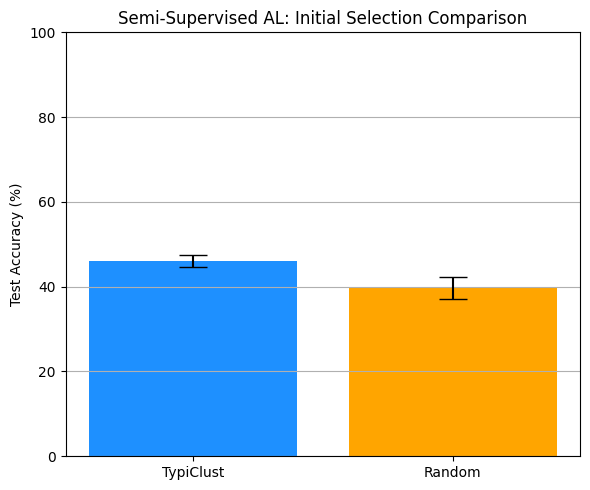

In [ ]:

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

n_runs = 2
methods = ["typiclust", "random"]

all_results = {m: [] for m in methods}

for run in range(n_runs):
    print(f"\n=== Semi-Supervised Run {run+1}/{n_runs} ===")
    seed_everything(run)
    np.random.seed(run)
    torch.manual_seed(run)
    random.seed(run)

    for m in methods:
        print(f"\nRun {run+1}, Method: {m.upper()}")
        test_acc = run_semi_supervised_experiment(
            simclr_embeddings=simclr_full_embeddings,
            method=m,
            initial_labeled=40,
            pseudo_threshold=0.95,
            num_epochs_ssl=50
        )
        all_results[m].append(test_acc)

typiclust_arr = np.array(all_results["typiclust"])
random_arr = np.array(all_results["random"])

# Compute means and standard errors.
typiclust_mean = typiclust_arr.mean()
typiclust_stderr = typiclust_arr.std() / np.sqrt(n_runs)
random_mean = random_arr.mean()
random_stderr = random_arr.std() / np.sqrt(n_runs)

# Save results to CSV.
np.savetxt(f"{results_dir}/semi_supervised_typiclust_runs.csv", typiclust_arr[None], delimiter=",", fmt="%.4f")
np.savetxt(f"{results_dir}/semi_supervised_random_runs.csv", random_arr[None], delimiter=",", fmt="%.4f")

with open(f"{results_dir}/semi_supervised_summary.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Method", "Mean", "StdErr"])
    writer.writerow(["TypiClust", typiclust_mean, typiclust_stderr])
    writer.writerow(["Random", random_mean, random_stderr])

print("Semi-Supervised Results:")
print(f"TypiClust: Mean = {typiclust_mean*100:.2f}%, StdErr = {typiclust_stderr*100:.2f}%")
print(f"Random:   Mean = {random_mean*100:.2f}%, StdErr = {random_stderr*100:.2f}%")

# Plot a bar chart.
methods_list = ["TypiClust", "Random"]
means = [typiclust_mean*100, random_mean*100]
stderrs = [typiclust_stderr*100, random_stderr*100]

plt.figure(figsize=(6, 5))
plt.bar(methods_list, means, yerr=stderrs, capsize=10, color=['dodgerblue','orange'])
plt.ylabel("Test Accuracy (%)")
plt.title("Semi-Supervised")
plt.ylim([0, 100])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f"{results_dir}/semi_supervised_comparison.png")
plt.show()

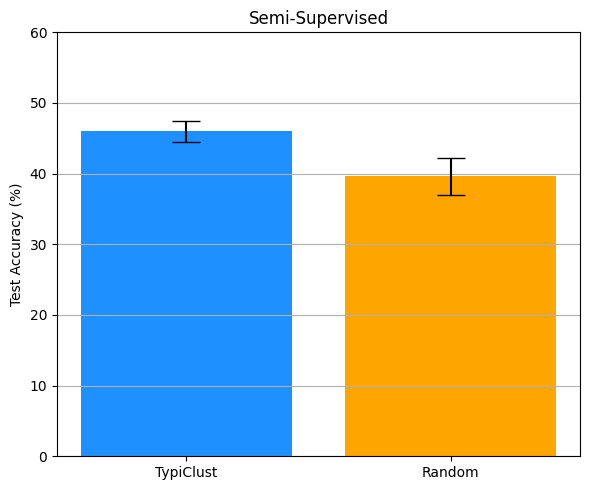

In [ ]:
plt.figure(figsize=(6, 5))
plt.bar(methods_list, means, yerr=stderrs, capsize=10, color=['dodgerblue','orange'])
plt.ylabel("Test Accuracy (%)")
plt.title("Semi-Supervised")
plt.ylim([0, 60])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f"{results_dir}/semi_supervised_comparison.png")
plt.show()